# Explore here

Cargamos librerias y CSV

In [1]:
#Importamos librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import warnings

df = pd.read_csv("/workspaces/machine-learning-vicentepolo/data/raw/medical_insurance_cost.csv", sep= ',' )

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Limpieza del DataSet

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Comprobmos que hay un total de 1337 valores y que no hay faltantes a primera vista 

In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Revisamos las columnas numéricas. Dado que su desviación estandar no es igual a 0, lo cual mostraría que en la columna se repite un unico valor, no vamos a eliminar ninguna

Comprobamos la relevancia de las columnas y que no hay ninguna con un único valor. Comprobamos pues, que no hay columnas con tan solo un subnivel, por lo que no eliminamos ninguna 

In [4]:
n_unicos = df.nunique()
n_unicos

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

Revisión de duplicados

In [5]:
duplicadas = df[df.duplicated(keep=False)]

duplicadas

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


Procedemos a eliminar los duplicados

In [6]:
df.drop(df[df.duplicated()].index, inplace=True)

Realizamos una segunda comprobación

In [7]:
df.duplicated().sum()

np.int64(0)

Comprobamos valores faltantes

<Axes: >

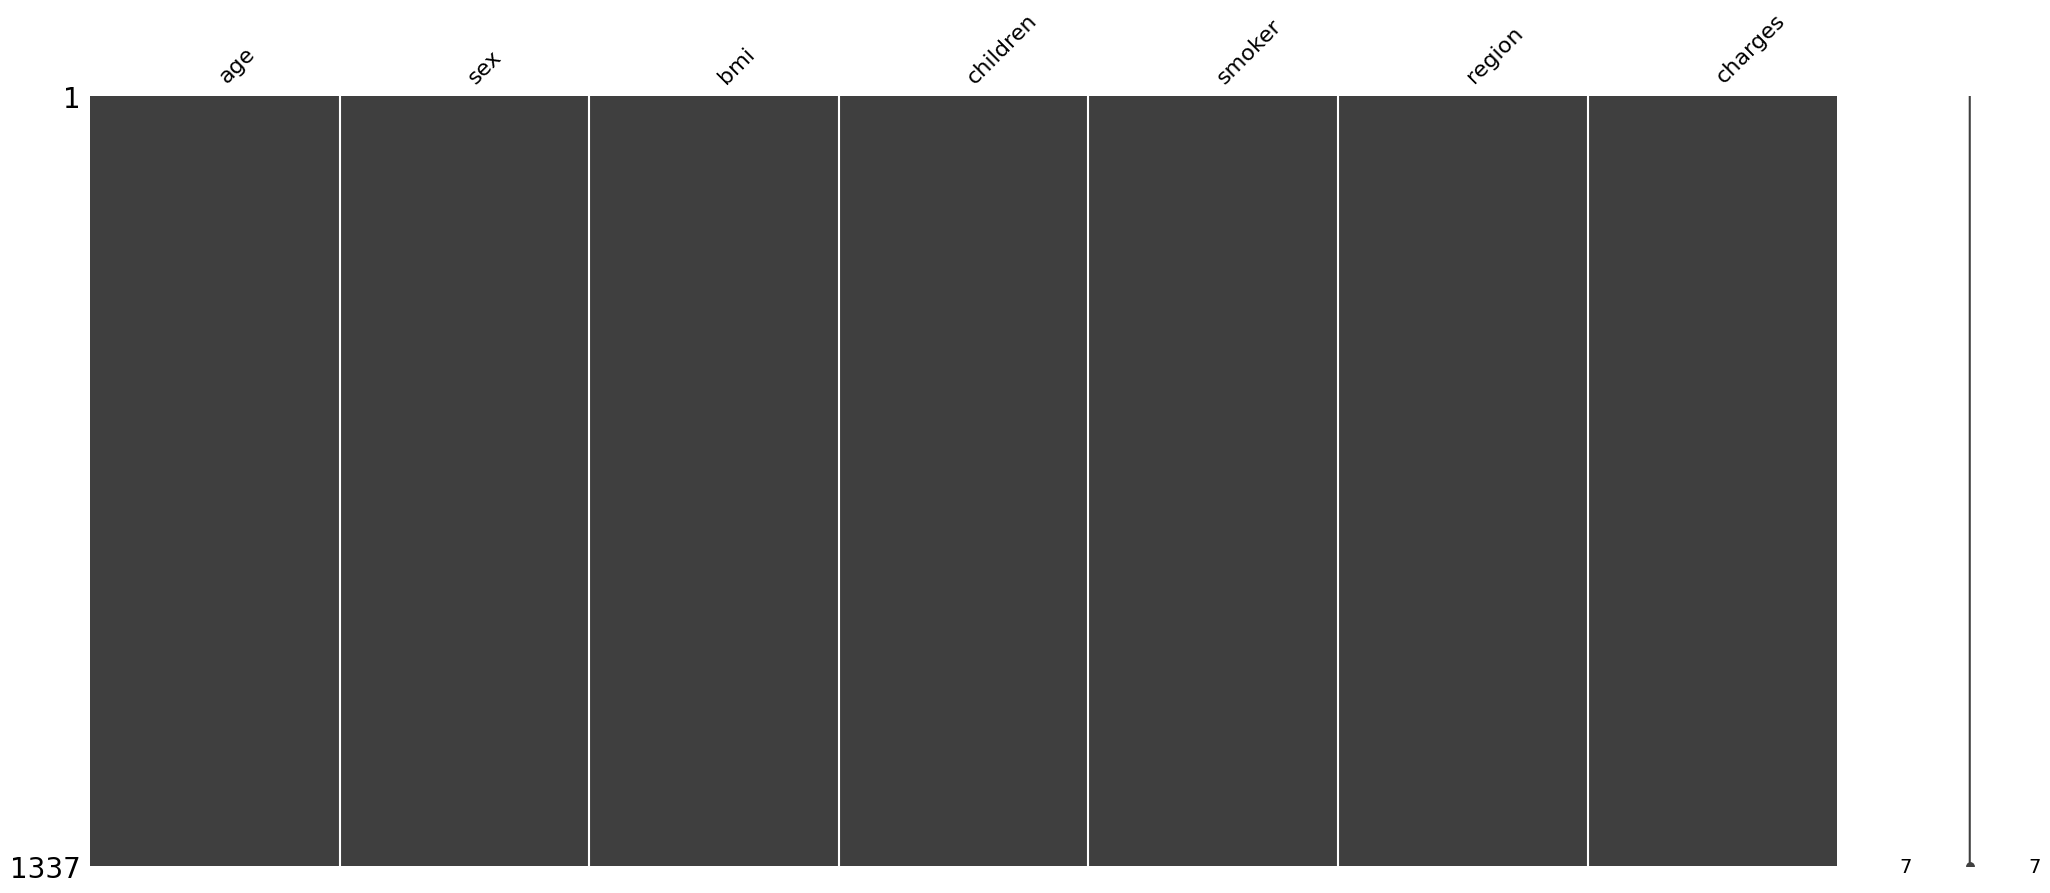

In [8]:
msno.matrix(df)

In [9]:
df.isnull().mean()*100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

Comprobación de columnas categóricas 

In [10]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Comprobamos si hay valores extremos o outliers. Crearemos un boxplot para las columnas numéricas

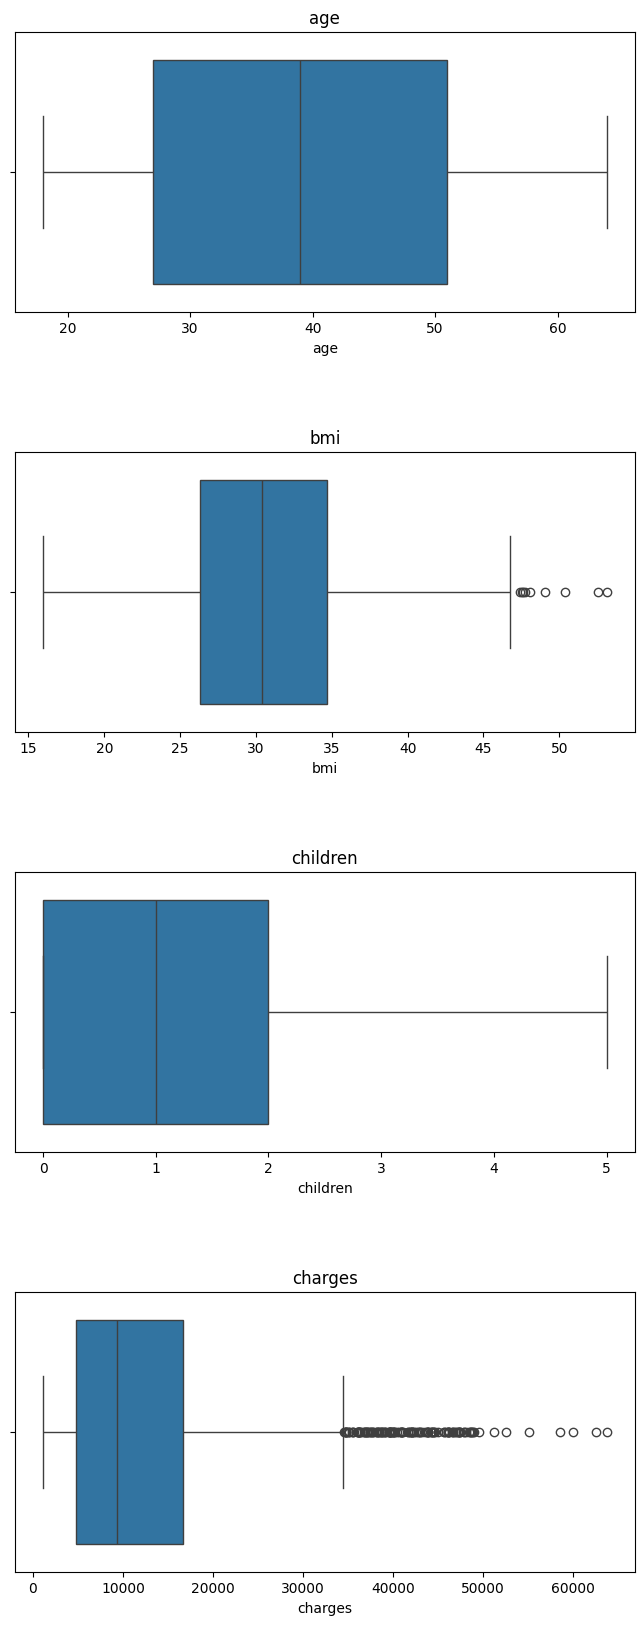

In [11]:
cols_num= ['age', 'bmi','children','charges']

fig, ax = plt.subplots(nrows=len(cols_num), ncols=1, figsize=(8, 5 * len(cols_num)))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=df, ax=ax[i],)
    ax[i].set_title(col)

plt.show()

Conclusiones: 

- Vemos que la edad con la que vamos a trabajar son gente desde un poco por debajo de los  años hasta ligeramente por encima de los 50
- Con respecto al BMI (IMC) Se considera que un IMC normal está entre 18.5 y 24.9. Este rango es el más saludable y está asociado con un menor riesgo de enfermedades. Estamos trabajando con valores por encima de esto, es decir, gente con grados diversos de obesidad, con el riesgo que eso conlleva
- Tienen entre 0 y 2 niños
- La media de importe que pagan oscila entre los 10.000 € o $

## Pasemos a comprobar si hay posibles errores en las columnas categóricas

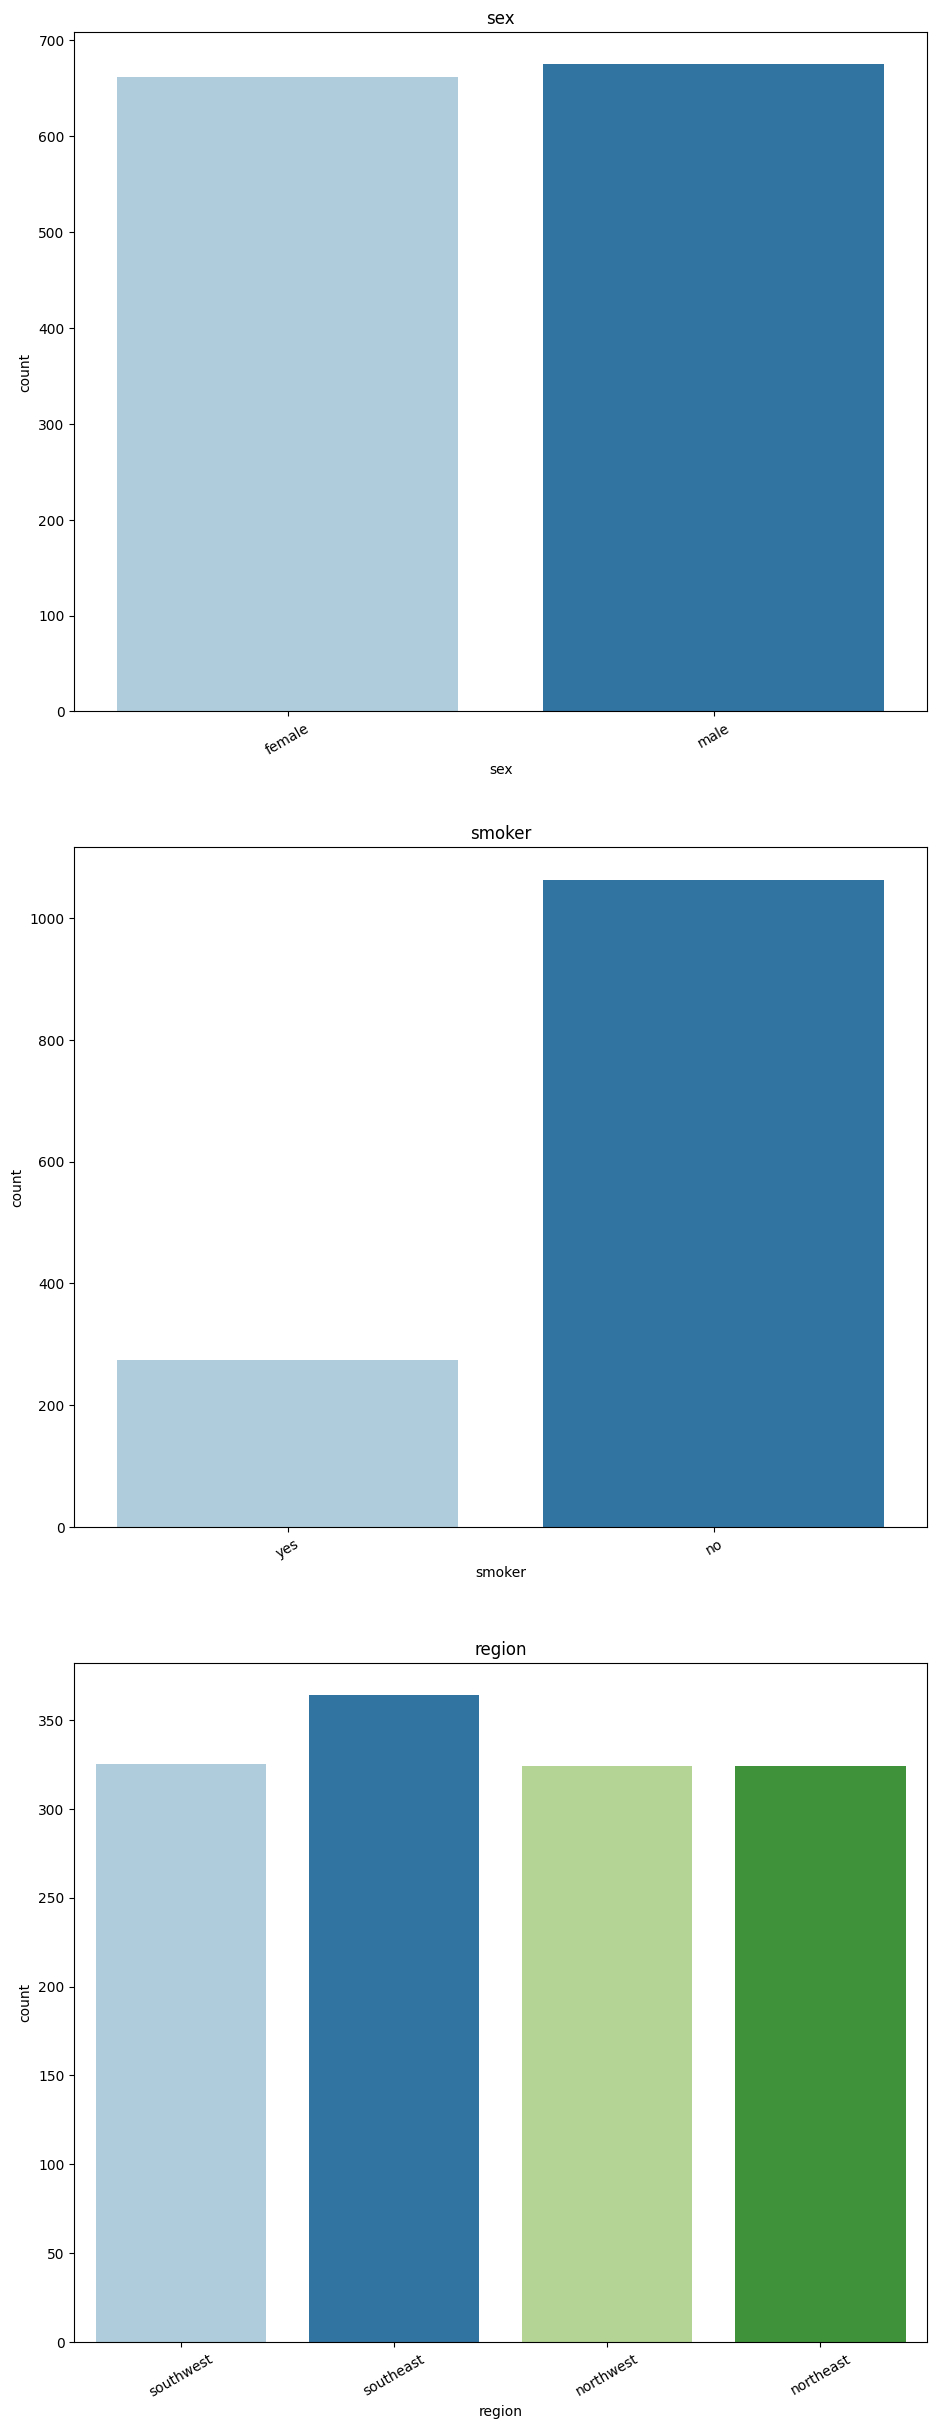

In [12]:
cols_cat = ['sex', 'smoker', 'region']
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, ax = plt.subplots(nrows=len(cols_cat), figsize=(11, 30))



for i, col in enumerate(cols_cat):
    sns.countplot(x=col, data=df, ax=ax[i],hue=col , palette="Paired")
    ax[i].set_title(col)
    # Rotar las etiquetas del eje x
    ax[i].tick_params(axis='x', rotation=30)


if len(cols_cat) == 1:
    ax = [ax]

plt.show()

Conclusiones: 

Lo principal, es que no se aprecian errores tipográficos o valores desconocidos que puedan afectar al estudio.

- No hay una gran diferencia entre los valores de hombre y mujer, esto nos puede llevar a pensar que podríamos crear una columna con los valores correspondientes al total de candidatos, aunque sesgaría quizá la información
- Estamos trabajando con una mayoría de no fumadores
- La región donde vive en USA tiene valores similares. Es una columna que yo personalmente eliminaría, dado que no aporta informacion relevante, dado que no hay grandes diferencias. 

## Análisis exploratorio

Como ya he comentado, creo que la región es una columna que no va a aportar datos significativos, dada su escasa diferencia. 

Me quedo con la duda si unir todos los valores de sex, pero dado que en si, es un dato que combinado puede darnos mas información, voy a mantenerlo.

In [13]:
df.drop(columns=['region'],inplace=True)

df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges'], dtype='object')

Pasamos a estudiar la variable charges que vamos a utilizar:

In [14]:
df['charges'].describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

La media es mayor que la mediana, por lo que la distribución está un poco sesgada a la derecha.


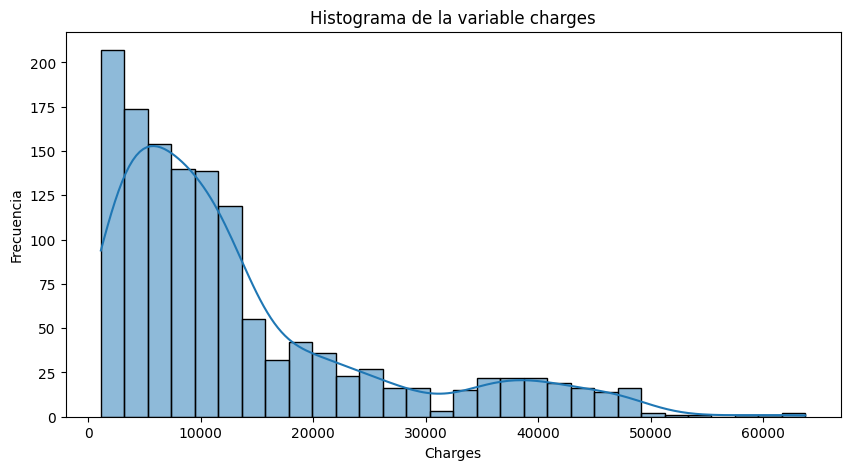

In [15]:
plt.figure(figsize=(10,5))
sns.histplot(df['charges'],bins=30, kde=True)
plt.title('Histograma de la variable charges')
plt.xlabel('Charges')
plt.ylabel('Frecuencia')

plt.show()

Como ya habíamos indicado solo mirando la media, la distribucion tiende a la derecha.

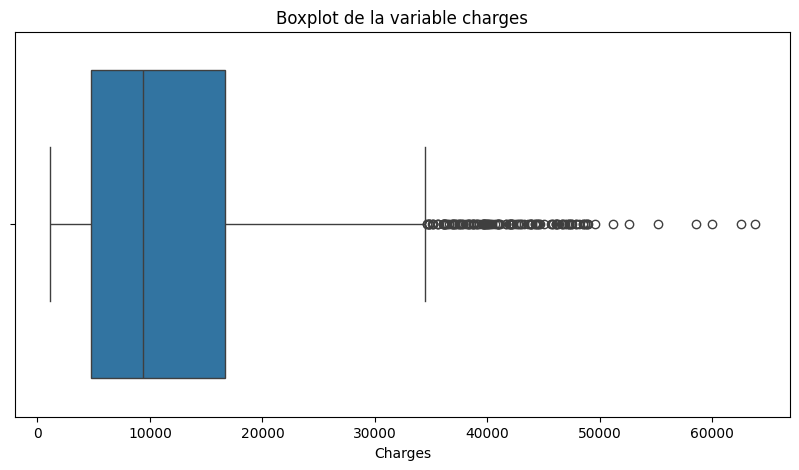

In [16]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['charges'])
plt.title('Boxplot de la variable charges')
plt.xlabel('Charges')
plt.show()

# Estudio univariado

## Variables numéricas

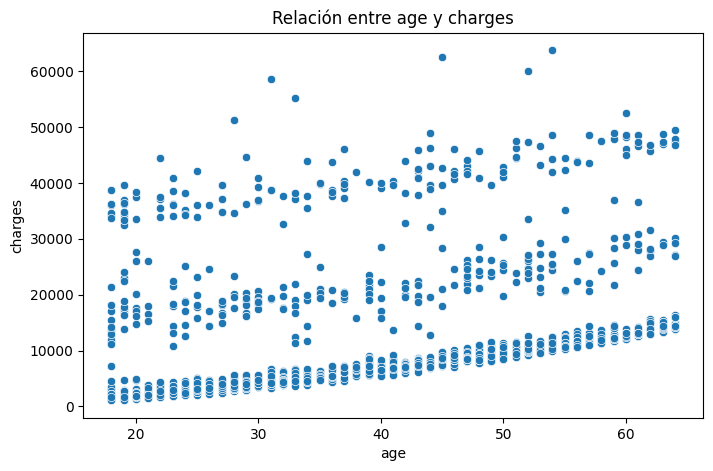

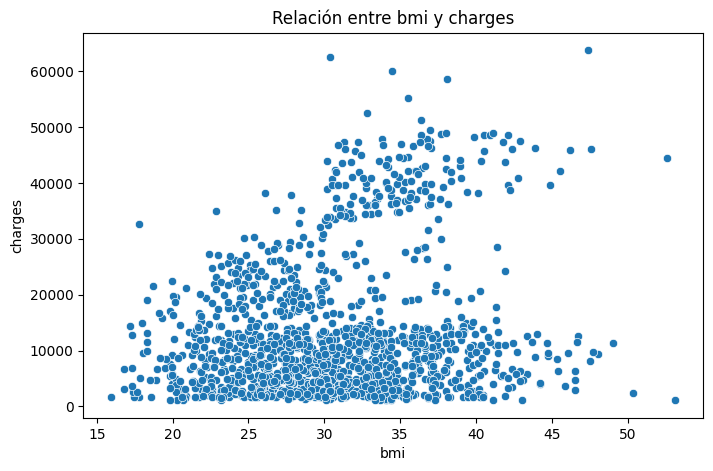

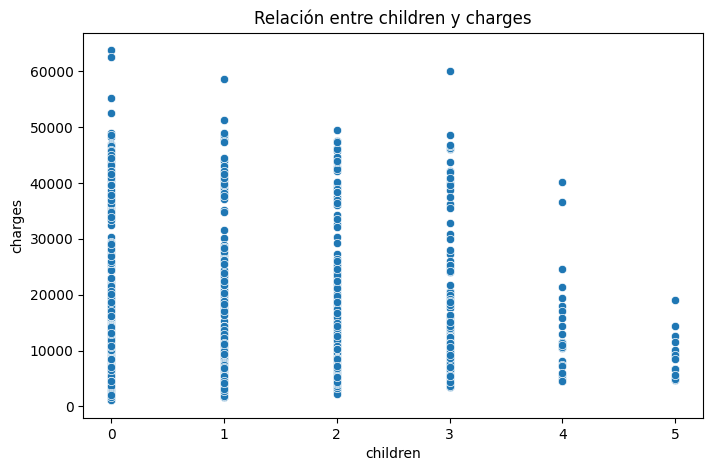

In [17]:
cols_num= ['age', 'bmi','children']
for col in cols_num:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=col, y='charges')
    plt.title(f'Relación entre {col} y charges')
    plt.xlabel(col)
    plt.ylabel('charges')
    plt.show()

-  Age y charges: Se aprecia una clara tendencia ascendente , incluso de los valores mínimos. Si bien es cierto que hay tres franjas claramente diferenciadas, como tres lineas paralelas que ascienden. 
- BMI y charges: Se da por entendido, por lógica común, que a mayor imc, mayor importe. Aunque en este caso, y según el gráfico, deberíamos decir: "A mayor BMI, mayor POSIBILIDAD de tener un cargo alto" dado que hay valores con BMI alto con importes bajos
- Niños y charges: Cuantos menos niños, mayor posibilidad de pagar más. La gente con 5 hijos no pagan valores muy por encima de la media (Como para pagar está esa pobre gente)

## Variables categóricas

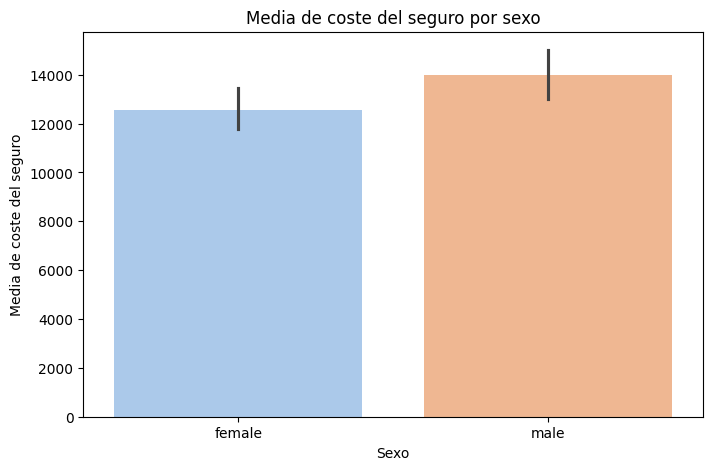

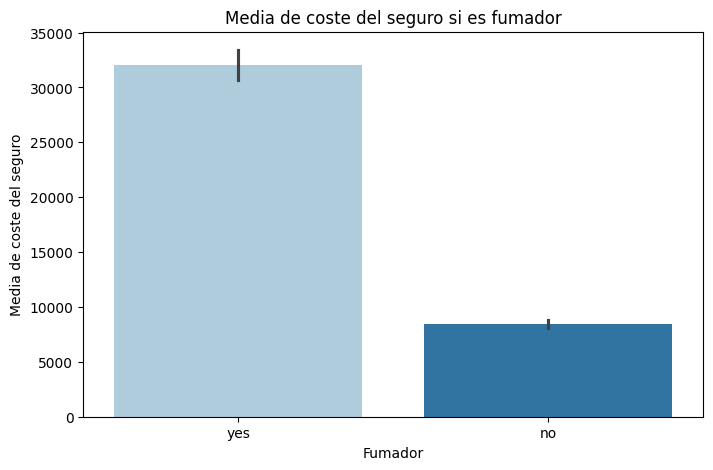

In [18]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='sex', y='charges', palette='pastel')
plt.title('Media de coste del seguro por sexo')
plt.xlabel('Sexo')
plt.ylabel('Media de coste del seguro')
plt.show()


plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='smoker', y='charges', palette='Paired')
plt.title('Media de coste del seguro si es fumador')
plt.xlabel('Fumador')
plt.ylabel('Media de coste del seguro')
plt.show()

Existe una diferencia poco significativa entre el importe que pagan hombres y mujeres, los hombres pagan más.

Evidentemente, los fumadores pagan un importe muchísimo mayor que los no fumadores por los riesgos que ello implica

### Análisis de correlación

In [19]:
df["sex"] = pd.factorize(df["sex"])[0]
df['smoker'] = df['smoker'].map({'yes': 0, 'no': 1})


In [20]:
df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
charges     float64
dtype: object

age         0.298308
sex         0.058044
bmi         0.198401
children    0.067389
smoker     -0.787234
charges     1.000000
Name: charges, dtype: float64


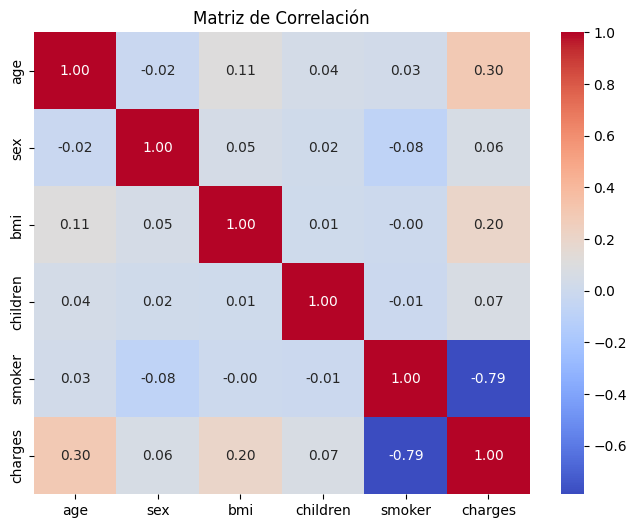

In [21]:
correlation_matrix = df.corr()
print(correlation_matrix['charges'])

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

- Age : Sin ser una correlación muy fuerte (30%) si que se demuestra como indicábamos que a medida que hay mayor edad, mayor el cargo.
- Sexo: La correlación es prácticamente de 0, por lo cual, como yo sospechaba, en este conjunto de datos no tiene relación significativa. Es candidato a ser eliminado
- BMI : Si que existe una correlación, a pesar de que no es muy grande (20%) entre a mayor bmi mayores son los importes
- Niños: Tambien es una correlación muy débil que nos indica que probablemente sea un valor del que podamos prescindir
- Fumador: Correlación negativa muy fuerte, que tal y como habíamos dicho, nos indica que ser fumador tiene un impacto severo en el importe a pagar
- Región: A pesar de que no lo muestro en el gráfico, quise comprobar si mi intuición era correcta, y el grado de correlación era 
de 0.006. 

In [22]:
df.drop(columns=['children','sex'],inplace=True)

In [23]:
df.head()

,age,bmi,smoker,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,1,4449.46200
3,33,22.705,1,21984.47061
4,32,28.880,1,3866.85520


Escalamos y aprovechamos para seleccionar las nuevas columnas para su estudio

In [24]:

num_variables = ["age", "bmi","smoker", "charges"]

scaler = MinMaxScaler()
scal_features = scaler.fit_transform(df[num_variables])
df_scal = pd.DataFrame(scal_features, index = df.index, columns = num_variables)
df_scal.head()

,age,bmi,smoker,charges
0,0.021739,0.321227,0.0,0.251611
1,0.000000,0.479150,1.0,0.009636
2,0.217391,0.458434,1.0,0.053115
3,0.326087,0.181464,1.0,0.333010
4,0.304348,0.347592,1.0,0.043816


# Procedemos a asignar valores a X e Y

In [25]:

X = df.drop(['charges',], axis=1)
y = df['charges']

In [27]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

X = df_scal.drop("charges", axis = 1)
y = df_scal["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

selection_model = SelectKBest(f_regression, k = 3)
selection_model.fit(X_train, y_train)

selected_columns = X_train.columns[selection_model.get_support()]
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = selected_columns)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = selected_columns)

X_train_sel.head()

,age,bmi,smoker
0,0.108696,0.230024,1.0
1,0.065217,0.263250,1.0
2,0.739130,0.580172,1.0
3,0.978261,0.686306,1.0
4,0.630435,0.286252,1.0


He de guardarlos en CSV porque si no por defecto me lo guarda como series

In [28]:
X_train_sel["charges"] = y_train.values
X_test_sel["charges"] = y_test.values
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

In [29]:
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

train_data.head()

,age,bmi,smoker,charges
0,0.108696,0.230024,1.0,0.020339
1,0.065217,0.263250,1.0,0.034446
2,0.739130,0.580172,1.0,0.516374
3,0.978261,0.686306,1.0,0.196070
4,0.630435,0.286252,1.0,0.137177


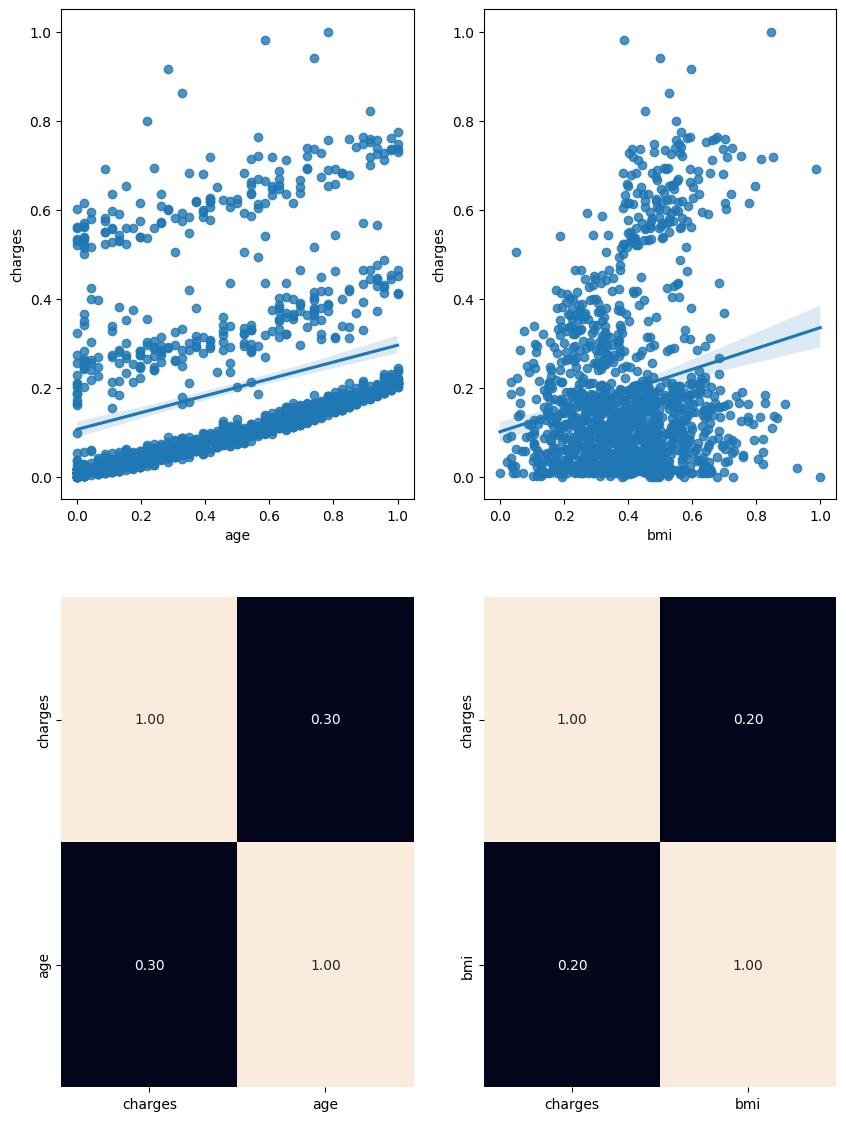

In [30]:
fig, axis = plt.subplots(2, 2, figsize = (10, 14))
df = pd.concat([train_data, test_data])

sns.regplot(data=df, x="age", y="charges", ax=axis[0, 0])
sns.heatmap(df[["charges", "age"]].corr(), annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)

sns.regplot(data=df, x="bmi", y="charges", ax=axis[0, 1])
sns.heatmap(df[["charges", "bmi"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1], cbar=False)

plt.show()

Ajustamos a un modelo de regresion lineal

In [31]:

X = sm.add_constant(X)  
# Ajustar el modelo a los datos
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1314.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        14:50:00   Log-Likelihood:                 1220.3
No. Observations:                1337   AIC:                            -2433.
Df Residuals:                    1333   BIC:                            -2412.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3328      0.009     35.841      0.0

- R-squared (R²): 75%. Por lo que entendemos que es un buen ajuste del modelo
- F-statistic nos muestra que al menos una de las variables con las que estamos trabajando es significativa
- Prob F-statistic (pvalues) es 0, que es el objetivo


In [32]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [33]:

print("Intercepto (a)")
# Coeficientes con nombres de variables
coef_dict = {
    'age': model.coef_[0],
    'bmi': model.coef_[1],
    'smoker': model.coef_[2],
    }

for variable, coef in coef_dict.items():
    print(f"{variable}: {coef}")



print("--------------------------------------------------------------------\n")

print("Coeficientes (b)")
# Coeficientes con nombres de variables
coef_dict = {
    'age': model.coef_[0],
    'bmi': model.coef_[1],
    'smoker': model.coef_[2],
    }

for variable, coef in coef_dict.items():
    print(f"{variable}: {coef}")

Intercepto (a)
age: 0.18494128584750963
bmi: 0.18084233893847657
smoker: -0.3683127577767232
--------------------------------------------------------------------

Coeficientes (b)
age: 0.18494128584750963
bmi: 0.18084233893847657
smoker: -0.3683127577767232


Confirmamos todos los puntos indicados anteriormente: 

En los coeficientes destacan:

- Cuanto mas años se tiene, mayor el recargo
- A mayor indice de masa corporal, mas se paga. 
- Por cada hijo adicional, mayor el cargo
- Los fumadores tienen cargos muy significativos

El coeficiente de smoker (si es fumador o no) tiene un valor extremadamente alto

In [34]:
y_pred = model.predict(X_test)
y_pred

array([ 0.1167114 ,  0.05131153,  0.19223372,  0.47043099,  0.12157934,
        0.18966623,  0.44936012,  0.01684343,  0.15644538,  0.14675449,
        0.15802393,  0.52065781,  0.47075384,  0.26948743,  0.13622594,
        0.13072129,  0.05113041,  0.49447418,  0.03000611,  0.07072398,
        0.05113041,  0.45956582,  0.21481971,  0.47296516,  0.48401833,
        0.058216  ,  0.54375044,  0.57928862,  0.15692291,  0.17647472,
        0.08594119,  0.19154597, -0.0040064 ,  0.18116943,  0.62624754,
        0.18160309,  0.02570273,  0.02784317,  0.49324859,  0.13157932,
        0.09227954,  0.44888415,  0.52636368,  0.17235906,  0.09217058,
        0.04826412,  0.0785087 ,  0.12851869,  0.04892093,  0.12430812,
        0.08329411,  0.17449345,  0.47430522,  0.05273595,  0.15320336,
        0.13638273,  0.1501734 ,  0.0202203 ,  0.48508869,  0.12383481,
        0.20893272,  0.11732434,  0.17360632,  0.00964071,  0.23670896,
        0.13880187,  0.14320311,  0.48661437,  0.38963674,  0.23

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 0.00913198057848913
Coefficient of determination: 0.8049502474643171


In [37]:
X = sm.add_constant(X)  
model = sm.OLS(y, X)  
results = model.fit()  

In [38]:
residuos = results.resid

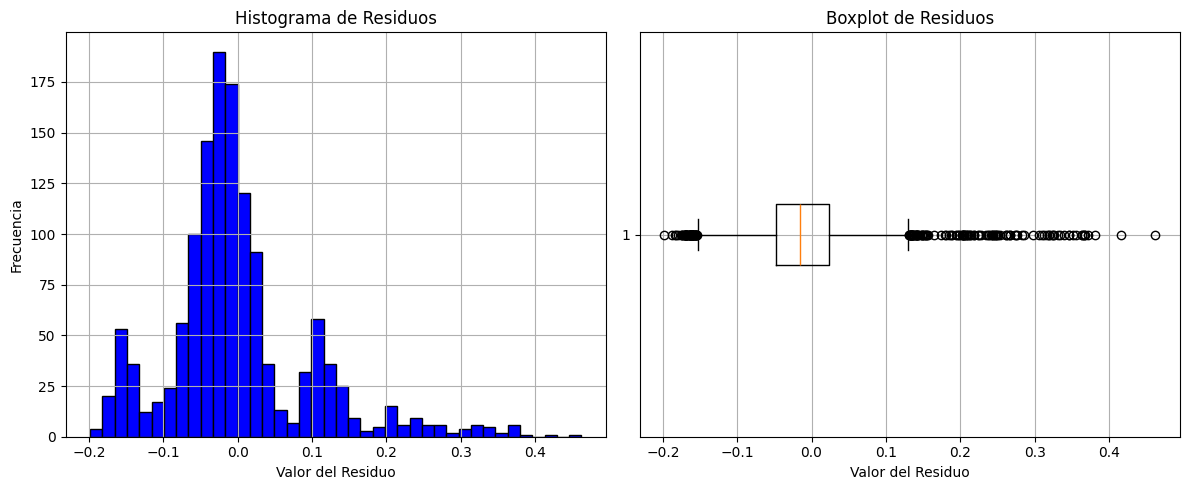

In [39]:
# Crea una figura con dos subgráficos (uno para el histograma y otro para el boxplot)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma de los residuos en el primer subgráfico (ax1)
ax1.hist(residuos, bins=40, color='blue', edgecolor='black')
ax1.set_title('Histograma de Residuos')
ax1.set_xlabel('Valor del Residuo')
ax1.set_ylabel('Frecuencia')
ax1.grid(True)

# Boxplot de los residuos en el segundo subgráfico (ax2)
ax2.boxplot(residuos, vert=False)
ax2.set_title('Boxplot de Residuos')
ax2.set_xlabel('Valor del Residuo')
ax2.grid(True)

# Muestra la figura con ambos gráficos
plt.tight_layout()  # Ajusta los márgenes para evitar superposiciones
plt.show()

In [40]:
np.mean(residuos)

np.float64(7.374637757439054e-16)

In [41]:
stats.shapiro(residuos)

ShapiroResult(statistic=np.float64(0.9031985359836083), pvalue=np.float64(2.8384706524821463e-28))

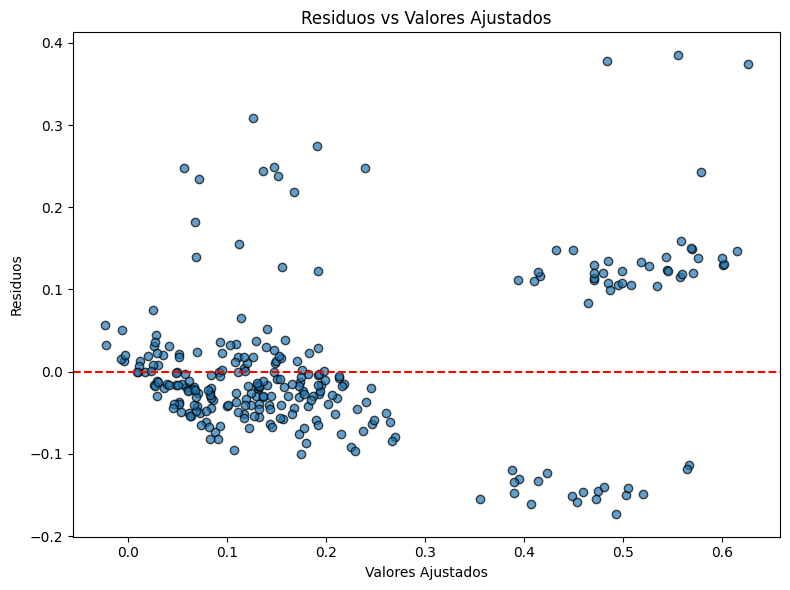

In [42]:

residuos = y_test - y_pred

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuos, edgecolors='k', alpha=0.7)

# Línea horizontal en y = 0 para mostrar los residuos
plt.axhline(0, color='red', linestyle='--')

# Etiquetas y título
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Ajustados')

# Mostrar gráfico
plt.tight_layout()
plt.show()


In [45]:

# Modelo OLS
ols_model = LinearRegression()
ols_model.fit(X_train_sel, y_train)
y_pred_ols = ols_model.predict(X_test_sel)

# Métricas para OLS
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)

print(f"Mean squared error (OLS): {mse_ols}")
print(f"Coefficient of determination (OLS): {r2_ols}")


Mean squared error (OLS): 9.939674574608468e-33
Coefficient of determination (OLS): 1.0


In [46]:
stats.shapiro(residuos)

ShapiroResult(statistic=np.float64(0.900640509736885), pvalue=np.float64(2.72491142848884e-12))